## Imports etc

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import  mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import sys 
import os
sys.path.append(os.path.abspath("../src"))

import functions as fnc

plt.style.use('tableau-colorblind10')

In [2]:
train = pd.read_csv('../data/train.csv')
test =  pd.read_csv('../data/test.csv')

## train test split

In [3]:
__TARGET__ = 'SalePrice'

In [4]:
train_train, train_test = train_test_split(train, 
                                           test_size = 0.3, 
                                           #stratify = train[__TARGET__], 
                                           shuffle=True, 
                                           random_state = 4213 )

In [5]:
train_train.shape, train_test.shape

((1022, 81), (438, 81))

## Feature engineering

basement % finished

In [6]:
train.columns.to_list()

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

### ratio bathrooms to bedrooms

In [7]:
def ratio_bed_bath(data):
    """Calculate the ratio of bedrooms to bathrooms"""
    data_ = data.copy()
    data_['FEAT_ratio_bed_bath'] = data_['BedroomAbvGr']/ (data_['FullBath']+ data_['HalfBath'])
    max_val = data_.loc[data_['FEAT_ratio_bed_bath']< 999999, 'FEAT_ratio_bed_bath'].max()
    data_.loc[data_['FEAT_ratio_bed_bath']> 999999, 'FEAT_ratio_bed_bath'] = max_val
    return data_

In [8]:
train_train = ratio_bed_bath(train_train)
train_test = ratio_bed_bath(train_test)
test = ratio_bed_bath(test)

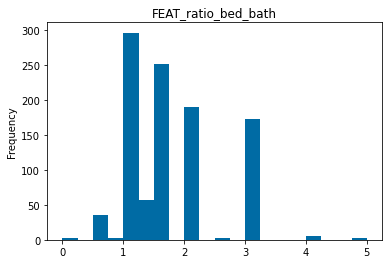

In [9]:
train_train['FEAT_ratio_bed_bath'].plot(kind='hist', title= 'FEAT_ratio_bed_bath', bins=20 );

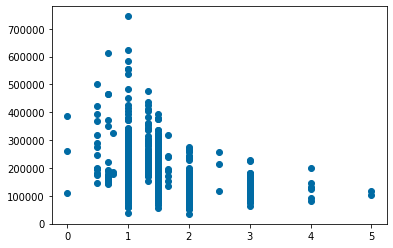

In [10]:
plt.scatter(train_train['FEAT_ratio_bed_bath'], train_train['SalePrice']);

### what % of lot area is covered by the home

In [11]:
def pct_lot_area_home(data):
    data_ = data.copy()
    data_['FEAT_pct_lotarea_house'] = 100*(data['1stFlrSF']/data['LotArea'])
    return data_

In [12]:
train_train = pct_lot_area_home(train_train)
train_test = pct_lot_area_home(train_test)
test = pct_lot_area_home(test)

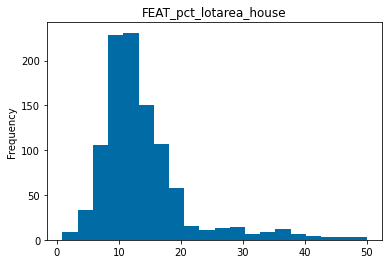

In [13]:
train_train['FEAT_pct_lotarea_house'].plot(kind='hist', title = 'FEAT_pct_lotarea_house', bins=20);

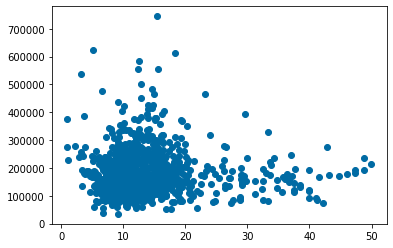

In [14]:
plt.scatter(train_train['FEAT_pct_lotarea_house'], train_train['SalePrice']);

### age of house

In [15]:
def age_of_house_years(data):
    data_ = data.copy()
    data_['FEAT_age_of_house'] = data_['YrSold'] - data_['YearBuilt']
    return data_

In [16]:
train_train = age_of_house_years(train_train)
train_test = age_of_house_years(train_test)
test = age_of_house_years(test)

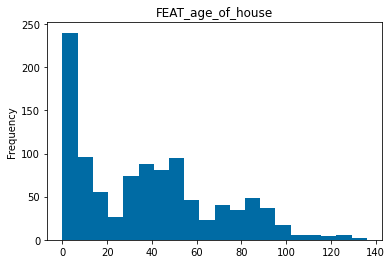

In [17]:
train_train['FEAT_age_of_house'].plot(kind='hist', bins=20, title='FEAT_age_of_house');

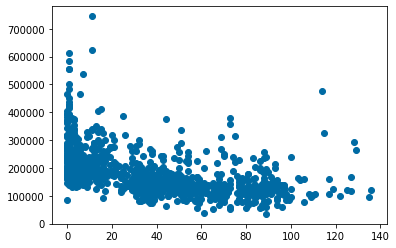

In [18]:
plt.scatter(train_train['FEAT_age_of_house'], train_train['SalePrice']);

### pct of basement finished

In [19]:
def pct_bsmt_unfinished(data):
    data_ = data.copy()
    data_['FEAT_pct_bsmt_unfinished'] = 100*data_['BsmtUnfSF']/ data_['TotalBsmtSF']
    return data_

In [20]:
train_train = pct_bsmt_unfinished(train_train)
train_test = pct_bsmt_unfinished(train_test)
test = pct_bsmt_unfinished(test)

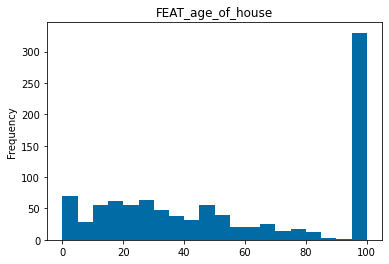

In [21]:
train_train['FEAT_pct_bsmt_unfinished'].plot(kind='hist', bins=20, title='FEAT_age_of_house');

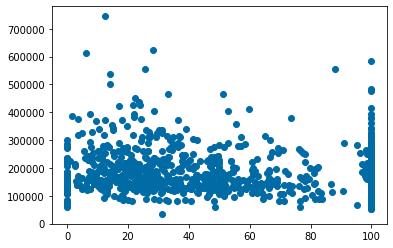

In [22]:
plt.scatter(train_train['FEAT_pct_bsmt_unfinished'], train_train['SalePrice'])

### remodel flag

In [23]:
def has_remodel(data):
    data_ = data.copy()
    data_['FEAT_has_remodel'] = 0
    data_.loc[(data_['YearBuilt'] != data['YearRemodAdd']), 'FEAT_has_remodel'] = 1
    return data_

In [24]:
train_train = has_remodel(train_train)
train_test = has_remodel(train_test)
test = has_remodel(test)

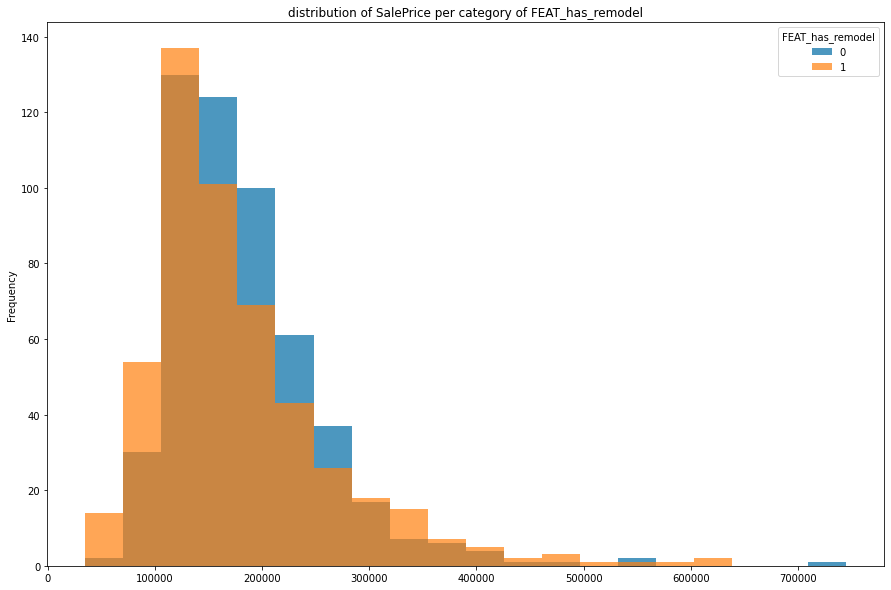

In [25]:
fnc.plot_distro_per_cat(train_train, 'SalePrice', 'FEAT_has_remodel', plt_args={'bins': 20, 'alpha': 0.7})

## select features

i want to end up with the list of features ranked from best to worst, for each selection method. then we can see which is best

In [26]:
feature_types = train_train.dtypes.to_frame('dtypes')
feature_types

int_cats = [ 'OverallCond', 'OverallQual', 'MoSold', 'MSSubClass']
data_dict = {}
data_dict['categorical'] = feature_types[feature_types['dtypes']=='object'].index.to_list() + int_cats
data_dict['continuous'] = [i for i in feature_types.index.to_list() if i not in data_dict['categorical'] and i not in ['Id', 'SalePrice']]

### remove features with > X% one value

In [27]:
def get_pct_val(data):
    data_ = data.copy()
    most_common = data_.apply(lambda x: x.value_counts(dropna=False).index[0], axis=0)
    pcts = (100*train[data_ == most_common].count()/data_.shape[0]).to_frame('pcts')
    return pcts

In [28]:
pct_one_val = get_pct_val(train_train)
pct_oneval_removals = pct_one_val[pct_one_val['pcts']> 80]

In [29]:
missing_pcts = (100*train_train.isnull().sum()/train_train.shape[0]).to_frame('% Missing').sort_values(by='% Missing', ascending= False)
missing_pcts = missing_pcts.loc[missing_pcts['% Missing']>80,]

In [30]:
pct_oneval_removals = missing_pcts.index.to_list() + pct_oneval_removals.index.to_list()

In [31]:
data_dict['continuous'] = [i for i in data_dict['continuous'] if i not in pct_oneval_removals]
data_dict['categorical'] = [i for i in data_dict['categorical'] if i not in pct_oneval_removals]

### NaN Imputation
just going to use the mean here to be quick

In [32]:
si = SimpleImputer(strategy='mean')

tmp = pd.DataFrame(si.fit_transform(train_train[data_dict['continuous']]))
tmp.columns = data_dict['continuous']
tmp.index = train_train.index
train_train = train_train[[i for i in train_train.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()
del tmp

tmp = pd.DataFrame(si.transform(train_test[data_dict['continuous']]))
tmp.columns = data_dict['continuous']
tmp.index = train_test.index
train_test = train_test[[i for i in train_test.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()

del tmp

tmp = pd.DataFrame(si.transform(test[data_dict['continuous']]))
tmp.columns = data_dict['continuous']
tmp.index = test.index
test = test[[i for i in test.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()
del tmp

train_train =train_train.copy()
train_test =train_test.copy()
test =test.copy()


train_train[data_dict['categorical']]= train_train[data_dict['categorical']].fillna('MISSING')
train_test[data_dict['categorical']]= train_test[data_dict['categorical']].fillna('MISSING')
test[data_dict['categorical']] = test[data_dict['categorical']].fillna('MISSING')


### standard scaler

In [33]:
sc = StandardScaler()

sc.fit(train_train[data_dict['continuous']])


tmp = pd.DataFrame(sc.transform(train_train[data_dict['continuous']]), 
                   columns = data_dict['continuous'], 
                   index = train_train.index)
train_train = train_train[[i for i in train_train.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()
del tmp

tmp = pd.DataFrame(sc.transform(train_test[data_dict['continuous']]), 
                   columns = data_dict['continuous'], 
                   index = train_test.index)
train_test = train_test[[i for i in train_test.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()
del tmp

tmp = pd.DataFrame(sc.transform(test[data_dict['continuous']]), 
                   columns = data_dict['continuous'], 
                   index = test.index)
test = test[[i for i in test.columns.to_list() if i not in data_dict['continuous']]].merge(tmp, left_index=True, right_index=True, how = 'left').copy()
del tmp

In [34]:
train_train

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,YrSold,FEAT_ratio_bed_bath,FEAT_pct_lotarea_house,FEAT_age_of_house,FEAT_pct_bsmt_unfinished,FEAT_has_remodel
406,407,50,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,-0.981365,-1.047918,-0.741186,-0.688035,0.153656,1.748367,-0.366157,1.117323,1.249079,1.023766
446,447,20,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0.338313,0.498599,-0.741186,-0.688035,1.656400,-1.343673,-0.321272,0.213049,-0.520796,1.023766
929,930,60,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,0.338313,0.791431,-0.741186,-0.688035,-1.349088,-0.460233,-0.852753,-0.917294,1.249079,-0.976786
926,927,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,1.657991,0.855488,0.096659,0.754458,-0.597716,-0.460233,-0.483486,-1.078771,1.249079,1.023766
897,898,90,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,0.338313,0.269824,0.499468,-0.688035,0.905028,1.748367,0.307494,-0.239088,0.000000,-0.976786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,501,160,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,-0.981365,-0.938106,0.418906,-0.284137,-0.597716,-0.239373,3.038971,-0.109906,-0.232544,-0.976786
198,199,75,RM,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,...,-2.301043,-2.146037,-0.741186,2.168101,0.905028,4.398686,0.428863,1.924711,1.249079,1.023766
814,815,50,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,-0.981365,-0.864898,0.926447,-0.688035,-1.349088,-0.239373,-0.757660,1.634052,1.249079,1.023766
544,545,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,0.338313,-0.196876,0.064434,-0.341837,-1.349088,-0.901953,-1.375839,-1.207953,-1.120051,-0.976786


### correlation (continuous features)

In [35]:
correlations = pd.DataFrame()
cont_feats = data_dict['continuous']

In [36]:
correlations['spearman'] = train_train[cont_feats+ ['SalePrice']].corr(method='spearman')['SalePrice'].abs()

In [37]:
correlations['pearson'] = train_train[cont_feats+ ['SalePrice']].corr(method='pearson')['SalePrice'].abs()

In [38]:
correlations

,spearman,pearson
LotFrontage,0.396601,0.355130
LotArea,0.465685,0.263516
YearBuilt,0.623777,0.493511
YearRemodAdd,0.563423,0.496131
MasVnrArea,0.401500,0.439390
BsmtFinSF1,0.313643,0.386856
BsmtUnfSF,0.159894,0.191081
TotalBsmtSF,0.598535,0.592082
1stFlrSF,0.575325,0.588855
2ndFlrSF,0.290417,0.318426


### mutual information (continuous features)

In [39]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(train_train[cont_feats], train_train['SalePrice'])

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7f922ab901f0>)

In [40]:
correlations = correlations.merge(pd.DataFrame(dict(zip(cont_feats, fs.scores_)), 
                                index=['Mutual Info']).T, left_index=True,right_index=True)

In [41]:
correlations

,spearman,pearson,Mutual Info
LotFrontage,0.396601,0.355130,0.202488
LotArea,0.465685,0.263516,0.185270
YearBuilt,0.623777,0.493511,0.299424
YearRemodAdd,0.563423,0.496131,0.246943
MasVnrArea,0.401500,0.439390,0.095622
BsmtFinSF1,0.313643,0.386856,0.129245
BsmtUnfSF,0.159894,0.191081,0.126213
TotalBsmtSF,0.598535,0.592082,0.346863
1stFlrSF,0.575325,0.588855,0.275169
2ndFlrSF,0.290417,0.318426,0.213405


### kendalls (categorical features)

here i am lazy and label encoding, and then assuming the ranks are ordered...

In [42]:
# we know the relative rankings for these
rankings= {'MISSING': -1,
    'Ex': 5,
'Gd': 4,
'TA': 3,
'Fa': 2,
'Po': 1}

for col in ['ExterQual','BsmtQual','HeatingQC','KitchenQual','FireplaceQu']:
    train_train[col] = train_train[col].replace(rankings)
    train_test[col] = train_test[col].replace(rankings)
    test[col] = test[col].replace(rankings)

In [43]:
# would be better to maybe do a one hot encoder here...

In [44]:
cols_to_impute = [i for i in data_dict['categorical'] if i not in ['ExterQual',
                                                                  'BsmtQual',
                                                                  'HeatingQC',
                                                                  'KitchenQual',
                                                                  'FireplaceQu', 
                                                                  'OverallCond',
                                                                  'OverallQual',	
                                                                  'MoSold',	
                                                                  'MSSubClass']]


    

In [45]:
cols_to_impute

['MSZoning',
 'LotShape',
 'LotConfig',
 'Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'GarageType',
 'GarageFinish']

In [46]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)

train_train[cols_to_impute] = ordinal_encoder.fit_transform(train_train[cols_to_impute] )
train_test[cols_to_impute] = ordinal_encoder.transform(train_test[cols_to_impute] )
test[cols_to_impute] = ordinal_encoder.transform(test[cols_to_impute] )

In [47]:
train_train[cols_to_impute] 

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,BsmtFinType1,GarageType,GarageFinish
406,3.0,3.0,4.0,18.0,0.0,1.0,8.0,8.0,3.0,0.0,4.0,6.0,5.0,3.0
446,3.0,0.0,0.0,12.0,2.0,1.0,3.0,10.0,3.0,1.0,4.0,0.0,1.0,0.0
929,3.0,0.0,0.0,8.0,5.0,1.0,6.0,6.0,1.0,2.0,4.0,6.0,3.0,0.0
926,3.0,3.0,4.0,16.0,5.0,3.0,12.0,13.0,1.0,2.0,4.0,6.0,3.0,0.0
897,3.0,3.0,4.0,20.0,5.0,1.0,9.0,10.0,3.0,3.0,2.0,4.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,4.0,3.0,4.0,2.0,5.0,1.0,6.0,6.0,1.0,1.0,4.0,1.0,5.0,3.0
198,4.0,3.0,0.0,17.0,3.0,1.0,13.0,14.0,3.0,1.0,4.0,6.0,6.0,1.0
814,3.0,3.0,4.0,7.0,0.0,1.0,11.0,12.0,3.0,0.0,4.0,6.0,5.0,3.0
544,3.0,0.0,4.0,8.0,5.0,1.0,12.0,13.0,3.0,2.0,0.0,2.0,1.0,2.0


In [55]:
correlations.merge(train_train[data_dict['categorical']+['SalePrice']].corr(
    method='kendall')['SalePrice'].abs().to_frame('kendells'), 
                   left_index=True, 
                   right_index=True, how= 'outer')

,spearman,pearson,Mutual Info,kendalls,kendells
1stFlrSF,0.575325,0.588855,0.275169,NaN,NaN
2ndFlrSF,0.290417,0.318426,0.213405,NaN,NaN
BedroomAbvGr,0.222692,0.158910,0.082712,NaN,NaN
BsmtExposure,NaN,NaN,NaN,NaN,0.170830
BsmtFinSF1,0.313643,0.386856,0.129245,NaN,NaN
BsmtFinType1,NaN,NaN,NaN,NaN,0.051452
BsmtFullBath,0.249930,0.249969,0.032444,NaN,NaN
BsmtQual,NaN,NaN,NaN,NaN,0.552495
BsmtUnfSF,0.159894,0.191081,0.126213,NaN,NaN
ExterQual,NaN,NaN,NaN,NaN,0.560297


In [56]:
import os

if not os.path.exists('../data/processed'):
    os.mkdir('../data/processed')


correlations.to_csv('../data/processed/correlations.csv')

train_train.to_csv('../data/processed/train_train.csv')
train_test.to_csv('../data/processed/train_test.csv')
test.to_csv('../data/processed/test.csv')
